In [1]:
import keras
import numpy as np
import sklearn
import pandas as pd

from keras.layers import Conv1D,Dense, Recurrent, Embedding, Flatten, GlobalMaxPool1D, LSTM, Input, merge
from keras.models import Model, load_model, save_model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import text_to_word_sequence, one_hot, Tokenizer

from keras.layers import merge, multiply, add
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *
from keras.optimizers import SGD

# from attention_utils import get_activations, get_data_recurrent

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error, precision_recall_curve

# In order to include a file from another location, run the following code.
import sys
sys.path.append('../edu/Models/') 
import labeled_functions

Using TensorFlow backend.


In [2]:
X_corpus, y = labeled_functions.load_with_path(path=r"/Users/ekremguzelyel/Desktop/Assignments/Research/MLLab-IIT/edu/active_learning")
X_sequence = []
for i in X_corpus:
    X_sequence.append(text_to_word_sequence(i))
X_train_sequence, X_test_sequence, y_train, y_test = train_test_split(X_sequence, y, test_size=1./3, random_state=42)

X_train_sequence[0], y_train[0]

Labeled Data loaded.


(['if', 'it', 'is', 'being', 'bad', 'on', 'purpose'], 0)

In [3]:
# Maximum sequence length
max_length=0
for i in X_sequence:
    max_length = [len(set(i)) if len(set(i)) > max_length else max_length][0]
len(X_train_sequence)
max_length

77

In [4]:
X_corpus_one_hot = []
for i in X_corpus:
    X_corpus_one_hot.append(one_hot(i, round(max_length*1.2)))

X_corpus_one_hot[4:7]

[[48],
 [57, 4, 63, 33, 35, 38, 3, 75, 89, 83, 90, 81],
 [45, 38, 44, 33, 31, 19, 13, 4, 45, 89]]

In [5]:
X_corpus_one_hot[17], X_corpus[17] # 'i' occurs twice (number 51) -> Checkmark

([53, 74, 17, 39, 52, 38, 82, 65, 65, 8, 74, 10, 70, 86, 54, 65, 5, 88],
 "if i did not dislike the phrase a great deal i would call `` straighthead '' a video nasty . ")

In [6]:
padded_seq_corpus = pad_sequences(X_corpus_one_hot)
X_train_padded_seq, X_test_padded_seq, y_train, y_test = train_test_split(padded_seq_corpus, y,
                                                                          test_size=1./3, random_state=42) 
# padded_seq_corpus.shape
len(padded_seq_corpus[0])

123

In [7]:
X_train_padded_seq[0], y_train[0], X_test_padded_seq[0], y_test[0]

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 53, 57,  4,
        17, 44, 35, 52], dtype=int32),
 0,
 array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  

# Sequence / Padding

### Apply attention to LSTM model

In [9]:
X_train_dim = np.reshape(X_train_padded_seq, (X_train_padded_seq.shape[0], 1, X_train_padded_seq.shape[1]))
X_test_dim = np.reshape(X_test_padded_seq, (X_test_padded_seq.shape[0], 1, X_test_padded_seq.shape[1]))

In [10]:
X_train_dim.shape

(2205, 1, 123)

In [11]:
## ATTENTION SET UP HERE 
TIME_STEPS=1
input_dim = int(X_train_dim.shape[2])
inputs = Input(shape=(TIME_STEPS, input_dim,))
a = Permute((2, 1))(inputs)
a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
a = Dense(TIME_STEPS, activation='softmax')(a)

# a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
# a = RepeatVector(input_dim)(a)

a_probs = Permute((2, 1), name='attention_vec')(a)
print(type(a_probs),type(inputs))
attention_mul = add([inputs, a_probs], name='attention_mul')

attention_mul = LSTM(32, return_sequences=False)(attention_mul)

output = Dense(1, activation='sigmoid')(attention_mul)
model = Model(input=[inputs], output=output)


print(model.summary())

<class 'tensorflow.python.framework.ops.Tensor'> <class 'tensorflow.python.framework.ops.Tensor'>
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 123)       0                                            
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 123, 1)       0           input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 123, 1)       0           permute_1[0][0]                  
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 123, 1)       2           reshape_1[0][0]                  
___________

/Users/ekremguzelyel/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__Question:__

When I change the TIME_STEP to 1, the model works fine. However, in the original document, it was 2, which causes problems for dimensions.

How does time steps change the attention behavior?

In [12]:
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=sgd)

In [13]:
model.fit(X_train_dim, y_train, validation_split=0.33, epochs=30, batch_size=32, verbose=1)
# model.fit(X_train_dim, y_train, epochs=20, batch_size=32, verbose=1)

Train on 1477 samples, validate on 728 samples
Epoch 1/30
1477/1477 [==============================] - 1s 786us/step - loss: 0.7490 - acc: 0.4590 - val_loss: 0.7266 - val_acc: 0.4739
Epoch 2/30
1477/1477 [==============================] - 0s 124us/step - loss: 0.7163 - acc: 0.4827 - val_loss: 0.7114 - val_acc: 0.4904
Epoch 3/30
1477/1477 [==============================] - 0s 101us/step - loss: 0.6937 - acc: 0.5389 - val_loss: 0.7090 - val_acc: 0.5110
Epoch 4/30
1477/1477 [==============================] - 0s 101us/step - loss: 0.6833 - acc: 0.5613 - val_loss: 0.7080 - val_acc: 0.5179
Epoch 5/30
1477/1477 [==============================] - 0s 129us/step - loss: 0.6810 - acc: 0.5674 - val_loss: 0.7056 - val_acc: 0.5206
Epoch 6/30
1477/1477 [==============================] - 0s 103us/step - loss: 0.6737 - acc: 0.5931 - val_loss: 0.7041 - val_acc: 0.5165
Epoch 7/30
1477/1477 [==============================] - 0s 107us/step - loss: 0.6722 - acc: 0.5877 - val_loss: 0.7049 - val_acc: 0.5206
E

/Users/ekremguzelyel/anaconda/lib/python3.6/site-packages/matplotlib/legend.py:641: UserWarning: Unrecognized location "left". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


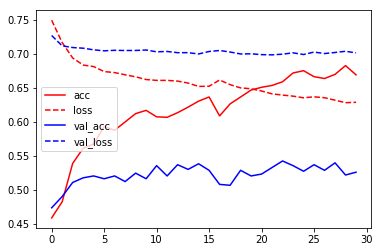

In [14]:
import matplotlib.pyplot as plt
plt.plot(model.history.epoch, model.history.history['acc'],'r-')
plt.plot(model.history.epoch, model.history.history['loss'],'r--')
plt.plot(model.history.epoch, model.history.history['val_acc'],'b-')
plt.plot(model.history.epoch, model.history.history['val_loss'],'b--')
plt.legend(['acc','loss','val_acc','val_loss'], loc='left')
plt.show()
# model.history.history

In [15]:
score_test = model.evaluate(X_test_dim, y_test,)
score_train = model.evaluate(X_train_dim, y_train)
score_test, score_train

2205/2205 [==============================] - 0s 30us/step


([0.7053341803395089, 0.5258386220752599],
 [0.6483002354498624, 0.6362811790166799])